In [37]:
# user defined functions
import odor_statistics_lib as osm

# dataframes
import pandas as pd
import h5py

#suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.TimeSeries = pd.Series 

#math
import numpy as np
import math
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import signal
from scipy import stats
import scipy.stats as st
from scipy.stats import kurtosis

#classification
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.ensemble import RandomForestClassifier

#plots
import string
import figurefirst
from figurefirst import FigureLayout,mpl_functions
import matplotlib.ticker as mtick
import pylab as plt
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from mpl_toolkits.axes_grid1 import make_axes_locatable # for colorbar
import seaborn as sns
from sklearn.inspection import DecisionBoundaryDisplay
from matplotlib.colors import ListedColormap
sns.set_style("whitegrid")
pd.options.mode.chained_assignment = None

In [38]:
dir = '~/DataAnalysis/data/Sprints/HighRes/'

In [39]:
# acc = pd.read_hdf(dir+'Classifier/accuracy_Scores_desert_nwindy.h5')

## Classify

In [40]:
def create_class_column_forest(dataframe):
    dataframe.loc[dataframe.avg_dist_from_source < 5, 'type'] = 0
    dataframe.loc[(dataframe.avg_dist_from_source >= 5)  & (dataframe.avg_dist_from_source < 10), 'type'] = 1
    dataframe.loc[dataframe.avg_dist_from_source >= 10, 'type'] = 2
    return dataframe

def create_class_column(dataframe):
    dataframe.loc[dataframe.avg_dist_from_source < 5, 'type'] = 0
    dataframe.loc[(dataframe.avg_dist_from_source >= 5)  & (dataframe.avg_dist_from_source < 30), 'type'] = 1
    dataframe.loc[dataframe.avg_dist_from_source >= 30, 'type'] = 2
    return dataframe

def create_class_column_fullts(dataframe):
    dataframe.loc[dataframe.distance_from_source < 5, 'type'] = 0
    dataframe.loc[(dataframe.distance_from_source >= 5)  & (dataframe.distance_from_source < 30), 'type'] = 1
    dataframe.loc[dataframe.distance_from_source >= 30, 'type'] = 2
    return dataframe

def create_class_column_log(dataframe):
    dataframe.loc[dataframe.log_avg_dist_from_source_signed < 0.7, 'type'] = 0
    dataframe.loc[(dataframe.log_avg_dist_from_source_signed >= 0.7)  & 
                  (dataframe.log_avg_dist_from_source_signed < 1.5), 'type'] = 1
    dataframe.loc[dataframe.log_avg_dist_from_source_signed >= 1.5, 'type'] = 2
    return dataframe

def check_length(dataframe, Nrows, nrows,N):
    if (len(Nrows) !=N):
        rowsneeded  = N - len(Nrows) 
        Nrows = Nrows.append(dataframe[(nrows.index-rowsneeded).values[0]:(nrows.index).values[0]])
        Nrows = Nrows.sort_index()
        return Nrows
    else:
        return Nrows
    
def get_rows(dataframe, N):
    nrows = dataframe.sample(1)
    Nrows = dataframe[(nrows.index).values[0]:(nrows.index+N).values[0]]
    newrows = check_length(dataframe,Nrows, nrows, N)
    return newrows

# for each collection of data to use for the classifier, get statistics from N encounters
def get_N_consecutive_encounter_stats(dataframe, distance_class, N):
    df_q = dataframe.query('type == ' + str(distance_class))   
    df_q.reset_index(inplace=True, drop=True)     
    Nrows = get_rows(df_q,N)
    
    return np.ravel( Nrows[['mean_concentration','mean_ef','log_whiff','mean_ma']].values )


# for each collection of data to use for the classifier, get statistics from N encounters
def get_N_random_encounter_stats(dataframe, distance_class,N):
    df_q = dataframe.query('type == ' + str(distance_class))   
    df_q.reset_index(inplace=True, drop=True)     
    Nrows = df_q.sample(N)
    avg_dist = np.mean(Nrows.avg_dist_from_source)
    return np.ravel( Nrows[['mean_concentration','mean_ef','log_whiff','mean_ma']].values ),avg_dist

def gather_stat_random(dataframe, distance_class, number_of_encounters,X,y,D):
    for i in range(500):
        xx,dx=get_N_random_encounter_stats(dataframe, distance_class, number_of_encounters)
        X.append(xx)
        D.append(dx)
        y.append(distance_class)
    return X,y,D

def gather_stat_consecutive(dataframe, distance_class, number_of_encounters,X,y):
    for i in range(2000):
        X.append(get_N_consecutive_encounter_stats(dataframe, distance_class, number_of_encounters))
        y.append(distance_class)
    return X,y

def stack_arrays(a):
    A = np.full((len(a), max(map(len, a))), np.nan)
    for i, aa in enumerate(a):
        A[i, :len(aa)] = aa
    return A

# def class_population_accuracy(ytest,y_pred):
    
#     cm = confusion_matrix(ytest, y_pred)
#     return ((cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]).diagonal())

def class_population_accuracy(ytest,y_pred):
    cm = confusion_matrix(ytest, y_pred)
    class_acc=[]
    # Calculate the accuracy for each one of our classes
    for idx, cls in enumerate([0,1,2]):
        # True negatives are all the samples that are not our current GT class (not the current row) 
        # and were not predicted as the current class (not the current column)
        tn = np.sum(np.delete(np.delete(cm, idx, axis=0), idx, axis=1))
        # True positives are all the samples of our current GT class that were predicted as such
        tp = cm[idx, idx]
        # The accuracy for the current class is ratio between correct predictions to all predictions
        class_acc.append((tp+tn)/np.sum(cm))
    return (class_acc)

In [64]:
def run_pca(feature_arr):
    dataframe = pd.DataFrame(index=range(len(feature_arr)),columns=range(len(feature_arr[0])))
    for i in range(len(feature_arr)):
        dataframe.iloc[i]=feature_arr[i]
        
    x=dataframe.loc[:,dataframe.columns.values].values
    
    x = StandardScaler().fit_transform(x)
    
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(x)
    return principalComponents

def box_cox_transform(dataframe):
    fitted_ef, fitted_lambda1 = stats.boxcox(dataframe.mean_ef)
    dataframe.mean_ma=dataframe.mean_ma+0.1
    fitted_ma, fitted_lambda2 = stats.boxcox(dataframe.mean_ma)
    fitted_wd, fitted_lambda3 = stats.boxcox(dataframe.length_of_encounter)
    fitted_mc, fitted_lambda3 = stats.boxcox(dataframe.mean_concentration)
    dataframe.std_whiff=dataframe.std_whiff+0.1
    fitted_sw, fitted_lambda3 = stats.boxcox(dataframe.std_whiff)
    dataframe['mean_ef']=fitted_ef
    dataframe['mean_ma']=fitted_ma
    dataframe['log_whiff']=fitted_wd
    dataframe['std_whiff']=fitted_mc
    dataframe['mean_concentration']=fitted_sw
    
def remove_motion_effect(dataframe):
    whiff_frequency=smf.ols(formula='mean_ef ~ (avg_perpendicular_encounter) + (avg_parallel_encounter)', data=dataframe).fit()
    whiff_duration=smf.ols(formula='log_whiff~ (avg_perpendicular_encounter) + (avg_parallel_encounter)', data=dataframe).fit()
    moving_avg = smf.ols(formula='whiff_ma ~ (avg_perpendicular_encounter) + (avg_parallel_encounter)', data=dataframe).fit()
    mc = smf.ols(formula='mean_concentration ~ (avg_perpendicular_encounter) + (avg_parallel_encounter)', data=dataframe).fit()
    sw = smf.ols(formula='std_whiff ~ (avg_perpendicular_encounter) + (avg_parallel_encounter)', data=dataframe).fit()


    dataframe['log_whiff']=whiff_duration.resid
    dataframe['mean_ef'] = whiff_frequency.resid
    dataframe['whiff_ma'] = moving_avg.resid
    dataframe['mean_concentration'] = mc.resid
    dataframe['std_whiff'] = sw.resid

In [65]:
def get_timed_rows(dataframe,duration_of_encounters):
    x = dataframe.sample(1)
    A = x.mean_time.values.round(0) - duration_of_encounters
    B = x.mean_time.values.round(0)
    timed_rows = dataframe.loc[(dataframe.mean_time > A[0]) & (dataframe.mean_time < B[0])]
    return timed_rows
    
def get_timed_encounter_stats(dataframe, distance_class, duration_of_encounters):
    df_q = dataframe.query('type == ' + str(distance_class))   
    df_q.reset_index(inplace=True, drop=True)     
            
    Nrows = get_timed_rows(df_q,duration_of_encounters)
    avg_dist = np.mean(Nrows.avg_dist_from_source)
    mean_time_whiff=np.mean(Nrows.mean_time)
#     mean_conc=np.mean(Nrows_cont.odor)
    pack_data=np.vstack([Nrows.mean_concentration,Nrows.mean_ef,Nrows.log_whiff,Nrows.whiff_ma,Nrows.std_whiff])
    return pack_data,avg_dist,len(Nrows),mean_time_whiff


def gather_stat_timed(dataframe, distance_class, duration_of_encounters,X,y,D,N,T):
    for i in range(500):
        xx,dx,n,t=get_timed_encounter_stats(dataframe,
                                               distance_class, duration_of_encounters)
        X.append(xx)
        D.append(dx)
        y.append(distance_class)
        N.append(n)
        T.append(t)
        
    return X,y,D,N,T

# def low_pass_filter(dataframe,cutoff):
#     fs=200
#     nyq=fs*0.5
    

#     sos = signal.butter(2, cutoff, 'low',fs=200, output='sos')
#     filtered = signal.sosfilt(sos, dataframe.mean_concentration)



#     return dataframe

In [66]:
df_windy=create_class_column_fullts(pd.read_hdf(dir+'Windy/WindyMASigned.h5'))
df_notwindy=create_class_column_fullts(pd.read_hdf(dir+'NotWindy/NotWindyMASigned.h5'))
df_forest=create_class_column_fullts(pd.read_hdf(dir+'Forest/ForestMASigned.h5'))

fdf_windy = pd.read_hdf(dir+'Windy/WindyStatsTime_std.h5')
fdf_notwindy = pd.read_hdf(dir+'NotWindy/NotWindyStatsTime_std.h5')
fdf_forest = pd.read_hdf(dir+'Forest/ForestStatsTime_std.h5')

In [67]:
# box_cox_transform(fdf_windy)
# box_cox_transform(fdf_notwindy)
# box_cox_transform(fdf_forest)

remove_motion_effect(fdf_windy)
remove_motion_effect(fdf_notwindy)
remove_motion_effect(fdf_forest)

# fdf_windy.to_hdf(dir+'Windy/WindyStatsTime.h5', key='fdf_windy', mode='w')
# fdf_notwindy.to_hdf(dir+'NotWindy/NotWindyStatsTime.h5', key='fdf_notwindy', mode='w')
# fdf_forest.to_hdf(dir+'Forest/ForestStatsTime.h5', key='fdf_forest', mode='w')

### Collect Train & Test features



In [68]:
lookback_time = 10

desert = pd.concat([fdf_notwindy,fdf_windy])
desert.reset_index(inplace=True, drop=True)
trainset= desert 
testset = fdf_forest

# desert_cont = pd.concat([df_notwindy,df_windy])
# desert_cont.reset_index(inplace=True, drop=True)



D_train=[]
D_test=[]
mean_time_train=[]
mean_time_test=[]
Xtest = []
ytest = []
Xtrain = []
ytrain = []
Nrows_train = []
Nrows_test = []
MCTest=[]
MCTrain=[]


for distance_class in [0,1,2]:
    Xtrain, ytrain, D_train,Nrows_train,mean_time_train = gather_stat_timed(trainset,
                                                                                    distance_class,
                      lookback_time, Xtrain,ytrain,D_train,Nrows_train,
                      mean_time_train)
    

# for distance_class in [0,1,2]:
#     Xtrain, ytrain, D_train,Nrows_train,mean_time_train,MCTrain = gather_stat_timed(trainset,desert_cont,
#                                                                                     distance_class,
#                       lookback_time, Xtrain,ytrain,D_train,Nrows_train,
#                       mean_time_train,MCTrain)
                                                                                             
                                                                                             
# for distance_class in [0,1]:
#     Xtest,ytest,D_test,Nrows_test,mean_time_test,MCTest = gather_stat_timed(testset,df_forest,distance_class,
#                       lookback_time, Xtest,ytest,D_test,Nrows_test,
#                       mean_time_test,MCTest)    


## Linear Distance Analysis - OLS


### Calculate statistics of timed train and test data

In [69]:
def calc_val(X):
    return np.ravel([np.min(X),np.max(X),np.mean(X),np.std(X),kurtosis(X)])
#     return np.ravel([np.min(X),np.max(X),np.mean(X),np.std(X),np.median(X),stats.mode(X[0])[0][0]])
column_names=['mc_min','mc_max','mc_mean','mc_std_dev','mc_k',
             'wf_min','wf_max','wf_mean','wf_std_dev','wf_k',
             'wd_min','wd_max','wd_mean','wd_std_dev','wd_k',
             'ma_min','ma_max','ma_mean','ma_std_dev','ma_k',
             'st_min','st_max','st_mean','st_std_dev','st_k']

## Done separately because Forest dataset has two classes
## Training set
traindf=pd.DataFrame(columns = column_names)
c1=[]
for i in range(len(Xtrain)):
    if(np.size(Xtrain[i])==0):
        c1.append(i)
        continue
    else:
        X=[]
        for j in range(len(Xtrain[i])):
            X.append(calc_val(Xtrain[i][j]))
        traindf.loc[i]=np.ravel(X)

## Test set
testdf=pd.DataFrame(columns = column_names)
c2=[]
for i in range(len(Xtest)):
    if(np.size(Xtest[i])==0):
        c2.append(i)
        continue
    else:
        Y=[]
        for j in range(len(Xtest[i])):
            Y.append(calc_val(Xtest[i][j]))
        testdf.loc[i]=np.ravel(Y)

In [70]:
traindf['distance']=np.delete(D_train, c1)
traindf['mean_whiff_time'] = np.delete(mean_time_train, c1)
traindf['nwhiffs'] = np.delete(Nrows_train, c1)
# traindf['mean_concentration_continuous'] = np.delete(MCTrain, c1)


# testdf['distance']=np.delete(D_test,c2)
# testdf['mean_whiff_time'] = np.delete(mean_time_test, c2)
# testdf['nwhiffs'] = np.delete(Nrows_test, c2)
# testdf['mean_concentration_continuous'] = np.delete(MCTest, c2)

In [71]:
# scaler = StandardScaler().fit(traindf[traindf.columns])
# traindf[traindf.columns]=scaler.transform(traindf[traindf.columns])
# testdf[testdf.columns]=scaler.transform(testdf[testdf.columns])

In [72]:
distance=smf.ols(formula=""" distance ~ mc_min+mc_max+mc_mean+mc_std_dev+mc_k+
wf_min+wf_max+wf_mean+wf_std_dev+wf_k+ wd_min+wd_max+wd_mean+wd_std_dev+wd_k+
ma_min+ma_max+ma_mean+ma_std_dev+ma_k+ st_min+st_max+st_mean+st_std_dev+st_k+nwhiffs""", data=traindf).fit()

distance.rsquared
# print(distance.summary())
# plt.rc('figure', figsize=(12, 7))

# plt.text(0.01, 0.05, str(distance.summary()), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
# plt.axis('off')
# plt.tight_layout()
# plt.savefig('../../Figure/olsresultsdesert.jpeg', dpi=300, bbox_inches = "tight")

0.6947385664575487

In [73]:
# result = np.where((dataframe.wf_std_dev) > 0.0000000001, (dataframe.wf_std_dev), -10)
# # print(result)
# np.log10(result, out=result, where=result > 0)

In [88]:
traindf.keys()

Index(['mc_min', 'mc_max', 'mc_mean', 'mc_std_dev', 'mc_k', 'wf_min', 'wf_max',
       'wf_mean', 'wf_std_dev', 'wf_k', 'wd_min', 'wd_max', 'wd_mean',
       'wd_std_dev', 'wd_k', 'ma_min', 'ma_max', 'ma_mean', 'ma_std_dev',
       'ma_k', 'st_min', 'st_max', 'st_mean', 'st_std_dev', 'st_k', 'distance',
       'mean_whiff_time', 'nwhiffs'],
      dtype='object')

/tmp/ipykernel_3452/3906745495.py:20: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar=f.colorbar(var1, cax=cax, orientation = 'vertical',ticks=[-2,2])


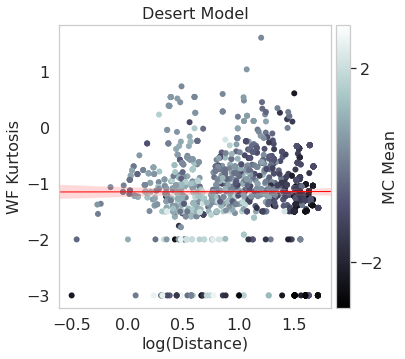

In [90]:
f, (ax) = plt.subplots(1,1, figsize=(5.5,5))
dataframe=traindf
distance = np.log10(dataframe.distance)
test_var=(dataframe.wf_k)
var1 = ax.scatter(distance,test_var, 
                   c=dataframe.mc_mean,cmap='bone', 
            edgecolors='none')
ax.grid(False)
# ax1.set_ylim(4.5,)
ax.set_title('Desert Model')
# #     ax1.set_title('Forest')
g1 = sns.regplot(x=distance,y=(test_var) , data=dataframe,
            ax=ax, line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
g1.set(xlabel=None, ylabel=None)

ax.set_xlabel('log(Distance)')
ax.set_ylabel('WF Kurtosis')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.08)
cbar=f.colorbar(var1, cax=cax, orientation = 'vertical',ticks=[-2,2])
cbar.solids.set(alpha=1)
# cbar.ax.set_yticklabels(['-33', '12'])
# cbar.ax.set_ylabel('#NWhiffs/LT=10sec', rotation=90, labelpad=0)
cbar.ax.set_ylabel('MC Mean', rotation=90, labelpad=0)


f.tight_layout(pad=1)
figurefirst.mpl_functions.set_fontsize(f, 16)
f.savefig('../../Figure/wf_k.jpeg', dpi=300, bbox_inches = "tight")

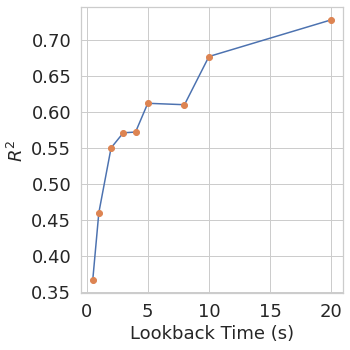

In [64]:
f,ax = plt.subplots(1,1,figsize=(5,5))
ax.plot([0.5,1,2,3,4,5,8,10,20],[0.366,0.46,0.55,0.571,0.572,0.612,0.61,0.677,0.728])
ax.plot([0.5,1,2,3,4,5,8,10,20],[0.366,0.46,0.55,0.571,0.572,0.612,0.61,0.677,0.728],'o')


ax.set_xlabel('Lookback Time (s)')
ax.set_ylabel('$R^2$')
# ax.set_xlim(0,)
# mpl_functions.adjust_spines(ax,['left','bottom'],spine_locations={}, 
#                                 smart_bounds=True,
# #                                 xticks=[0.5,1,2,3,4,5,8,10,20],
# #                                 yticks=[-10,20,60],
#                                 linewidth=1)
figurefirst.mpl_functions.set_fontsize(f, 18)
f.tight_layout(pad=1)
# plt.show()
# f.savefig('../../Figure/Rsquarelookback.jpeg', dpi=300, bbox_inches = "tight")

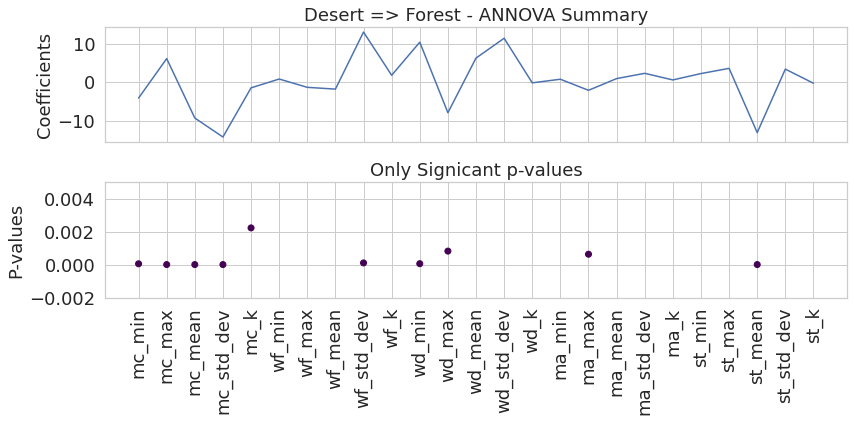

In [65]:
res_ = distance.params.to_frame()
res=pd.DataFrame()
res['parameter']=np.array(res_.index[1:])
res['coefficients']=np.array(res_.values[1:,0])
res['pvalues']=distance.pvalues.values[1:]


f,(ax1,ax2)=plt.subplots(2,1,figsize=(12,6))
# ax.grid(False)
ax1.plot(res.parameter,res.coefficients)
ax1.set_ylabel('Coefficients')
ax1.set_xticklabels([])
ax1.set_title('Desert => Forest - ANNOVA Summary')
var = ax2.scatter(res.parameter,res.pvalues,c=res.pvalues,cmap='viridis')
ax2.set_ylabel('P-values')
ax2.set_ylim(-0.002,0.005)
ax2.set_xticks(res.parameter)
ax2.set_xticklabels(res.parameter, rotation='vertical')
ax2.set_title('Only Signicant p-values')
# l=np.array([0,0.005,1])
# ax2.set_yticklabels(l)
# divider = make_axes_locatable(ax2)
# cax = divider.append_axes('right', size='5%', pad=0.08)
# cbar=f.colorbar(var, cax=cax, orientation = 'vertical')
# cbar.solids.set(alpha=1)

figurefirst.mpl_functions.set_fontsize(f, 18)
f.tight_layout(pad=1)
# plt.show()
# f.savefig('../../Figure/coeff_pval_.jpeg', dpi=300, bbox_inches = "tight")

In [75]:
column_names=['mc_min','mc_max','mc_mean','mc_std_dev','mc_k',
             'wf_min','wf_max','wf_mean','wf_std_dev','wf_k',
             'wd_min','wd_max','wd_mean','wd_std_dev','wd_k',
             'ma_min','ma_max','ma_mean','ma_std_dev','ma_k',
             'st_min','st_max','st_mean','st_std_dev','st_k']
y=traindf.distance
x=traindf.loc[traindf.distance.notnull(), column_names].values
x = sm.add_constant(x)

olsmod = sm.OLS(y, x)
olsres = olsmod.fit()
ypred = olsres.predict(x)
# print(olsres.summary())

In [162]:
import itertools
column_names=['mc_min','mc_max','mc_mean','wd_max','wd_mean','ma_max','st_max','st_mean']

rsquaredres=[]
aicres=[]
para_list = []
for i in range(len(column_names)):    
    sub_parameter_list = list(itertools.combinations(column_names,i))
    for elements in sub_parameter_list:
        para_list.append(elements)
        y=traindf.distance
        x = sm.add_constant(traindf.loc[traindf.distance.notnull(), elements].values)
        olsmod = sm.OLS(y, x)
        olsres = olsmod.fit()
        rsquaredres.append(olsres.rsquared)
        aicres.append(olsres.aic)
            

In [ ]:
combtest=pd.DataFrame()
combtest['rsquared']=rsquaredres
combtest['aic']=aicres
combtest['parameters']=para_list
combtest['fpvalue']=pval

In [76]:
## Test Dataset
Xnew = testdf.loc[testdf.distance.notnull(), column_names].values
Xnew = sm.add_constant(Xnew) 
ynewpred = olsres.predict(Xnew)

traindf['predicted_distance']=ypred
testdf['predicted_distance']=ynewpred

#Compute Accuracy with some tolerance

accuracy_train = {i for i in traindf.distance if np.isclose(traindf.predicted_distance, i, 0.1).any()}
accuracy_test = {i for i in testdf.distance if np.isclose(testdf.predicted_distance, i, 0.1).any()}

print('Accuracy Train Dataset: ',(len(accuracy_train)/len(traindf.predicted_distance)) *100 )
print('Accuracy Test Dataset: ',(len(accuracy_test)/len(testdf.predicted_distance)) *100 )

Accuracy Train Dataset:  46.19799139167862
Accuracy Test Dataset:  57.74647887323944


/tmp/ipykernel_41315/317429085.py:2: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  hist = ax[0].hist2d(traindf.distance, traindf.distance-traindf.predicted_distance, bins=50,cmap='cividis')
/tmp/ipykernel_41315/317429085.py:3: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  hist1 = ax[1].hist2d(testdf.distance, testdf.distance-testdf.predicted_distance, bins=50,cmap='cividis')
/tmp/ipykernel_41315/317429085.py:10: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar=f.colorbar(hist1[3], cax=cax, orientation = 'vertical')


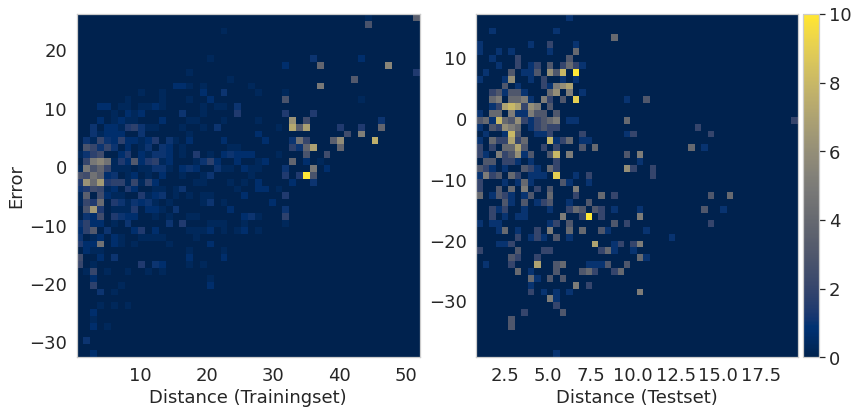

In [77]:
f, ax = plt.subplots(1,2,figsize=(12,6))
hist = ax[0].hist2d(traindf.distance, traindf.distance-traindf.predicted_distance, bins=50,cmap='cividis')
hist1 = ax[1].hist2d(testdf.distance, testdf.distance-testdf.predicted_distance, bins=50,cmap='cividis')
ax[0].set_ylabel('Error')
ax[0].set_xlabel('Distance (Trainingset)')
ax[1].set_xlabel('Distance (Testset)')

divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.08)
cbar=f.colorbar(hist1[3], cax=cax, orientation = 'vertical')
cbar.solids.set(alpha=1)
# f.colorbar(hist1[3], ax=ax[1])

f.tight_layout(pad=2)
figurefirst.mpl_functions.set_fontsize(f, 18)

# f.savefig('../../Figure/Hist2d_Dist.jpeg', dpi=300, bbox_inches = "tight")

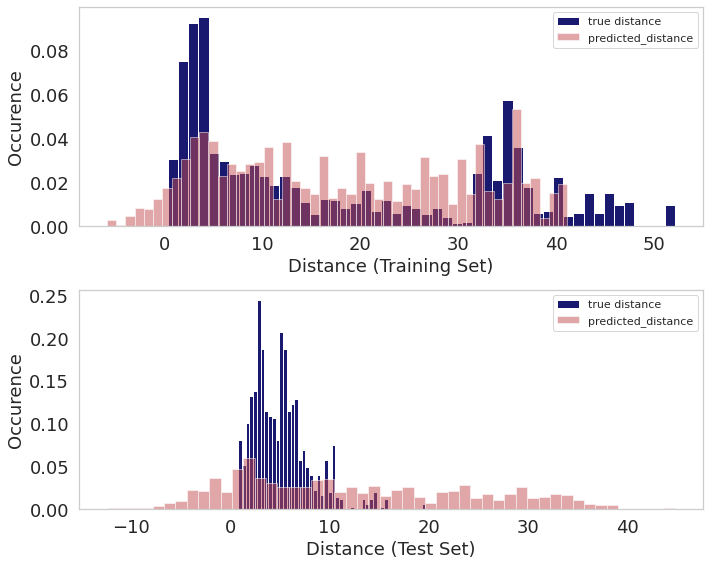

In [78]:
f,(ax1,ax2)=plt.subplots(2,1,figsize=(10,8))
n, bins, patches = ax1.hist(traindf.distance, 50, density=True, 
                            facecolor='midnightblue', label='true distance')
n1, bins1, patches1 = ax1.hist(traindf.predicted_distance, 50, 
                               density=True, facecolor='r', alpha=0.5,label='predicted_distance')

n2, bins2, patches2 = ax2.hist(testdf.distance, 50, density=True, 
                            facecolor='midnightblue', label='true distance')
n3, bins3, patches3 = ax2.hist(testdf.predicted_distance, 50, 
                               density=True, facecolor='r', alpha=0.5,label='predicted_distance')
ax1.grid(False)
ax1.set_ylabel('Occurence')
ax1.set_xlabel('Distance (Training Set)')
ax2.grid(False)
ax2.set_ylabel('Occurence')
ax2.set_xlabel('Distance (Test Set)')
figurefirst.mpl_functions.set_fontsize(f, 18)
ax1.legend(loc='upper right')
ax2.legend(loc='upper right')
f.tight_layout(pad=1)
# f.savefig('../../Figure/Hist_Dist.jpeg', dpi=300, bbox_inches = "tight")

In [79]:
train_sorted=traindf.sort_values(by=['mean_whiff_time'])
test_sorted=testdf.sort_values(by=['mean_whiff_time'])
train_sorted.reset_index(inplace=True, drop=True)  
test_sorted.reset_index(inplace=True, drop=True)  

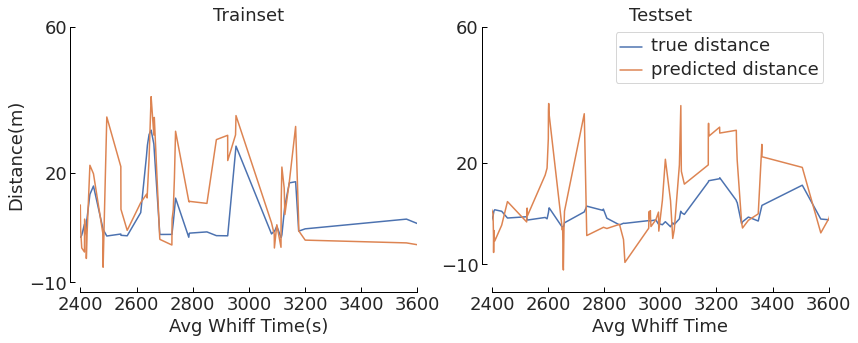

In [80]:
f,(ax1,ax2)=plt.subplots(1,2,figsize=(12,5))
ax1.plot(train_sorted.mean_whiff_time,train_sorted.distance)
ax1.plot(train_sorted.mean_whiff_time,train_sorted.predicted_distance)

ax2.plot(test_sorted.mean_whiff_time,test_sorted.distance,label='true distance')
ax2.plot(test_sorted.mean_whiff_time,test_sorted.predicted_distance,label='predicted distance')

ax1.grid(False)
ax2.grid(False)
ax1.set_title('Trainset')
ax2.set_title('Testset')
ax1.set_xlabel('Avg Whiff Time(s)')
ax1.set_ylabel('Distance(m)')
ax2.set_xlabel('Avg Whiff Time')

ax1.set_xlim(2500,3500)
ax2.set_xlim(2500,3500)
mpl_functions.adjust_spines(ax1,['left','bottom'],spine_locations={}, 
                                smart_bounds=True,
#                                 xticks=[0,3000,6000],
                                yticks=[-10,20,60],
                                linewidth=1)
mpl_functions.adjust_spines(ax2,['left','bottom'],spine_locations={}, 
                                smart_bounds=True,
#                                 xticks=[0,3000,7000],
                                yticks=[-10,20,60],
                                linewidth=1)
ax2.legend()
f.tight_layout(pad=2)
figurefirst.mpl_functions.set_fontsize(f, 18)
# f.savefig('../../Figure/actualvspredicteddist5.jpeg', dpi=300, bbox_inches = "tight")

In [81]:
# ## what if i run a lpf filer on predicted results


# # def smooth(y, box_pts):
# #     box = np.ones(box_pts)/box_pts
# #     y_smooth = np.convolve(y, box, mode='same')
# #     return y_smooth
# # fs=200
# # nyq=fs*0.5
# # cutoff_freq=95

# # sos = signal.butter(2, cutoff_freq, 'low',fs=200, output='sos')
# # filtered = signal.sosfilt(sos, testdf.predicted_distance)
# yhat = smooth(testdf.predicted_distance,10)


# accuracy_test = {i for i in testdf.distance if np.isclose(yhat, i, 0.1).any()}
# print('Accuracy Test Dataset: ',(len(accuracy_test)/len(yhat)) *100 )

In [82]:

## For plotting - df sorted with respect to mean whiff times
T1 = traindf.sort_values(by=['mean_whiff_time'])
T1.reset_index(inplace=True, drop=True)
T2 = testdf.sort_values(by=['mean_whiff_time'])
T2.reset_index(inplace=True, drop=True)

In [89]:
accuracy_train = {i for i in T1.predicted_distance if np.isclose(T1.distance, i, 0.1).any()}
accuracy_test = {i for i in T2.predicted_distance if np.isclose(T2.distance, i, 0.1).any()}

print('Accuracy Train Dataset: ',(len(accuracy_train)/len(T1.predicted_distance)) *100 )
print('Accuracy Test Dataset: ',(len(accuracy_test)/len(T2.predicted_distance)) *100 )

Accuracy Train Dataset:  43.90243902439025
Accuracy Test Dataset:  33.04442036836403


### $AIC$ and $R^2$

In [154]:
rsquared = pd.read_hdf(dir+'Forest/Forest_Rsquared.h5')
aic = pd.read_hdf(dir+'Forest/Forest_Aic.h5')

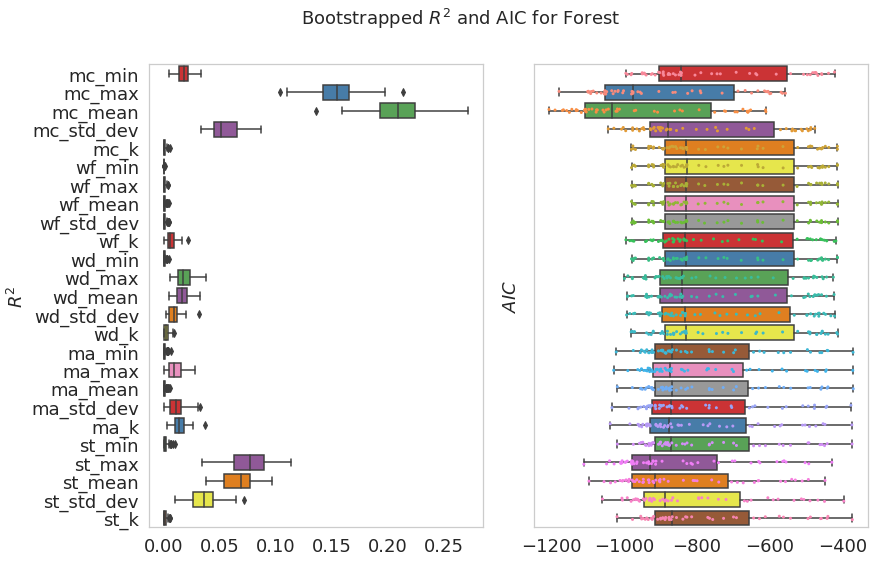

In [170]:
f,(ax,ax1)=plt.subplots(1,2,figsize=(12,8))
ax.grid(False)
ax.set_ylabel('$R^2$')
sns.boxplot(data=rsquared, ax=ax, orient="h" ,palette='Set1')
ax.set_yticklabels(rsquared.columns)

ax1.grid(False)
ax1.set_ylabel('$AIC$')
sns.boxplot(data=aic, ax=ax1,orient="h", dodge=True,  palette='Set1')
sns.stripplot(data=aic, ax=ax1,orient="h", dodge=True, size=3)
ax1.set_yticklabels("", rotation='vertical')
f.suptitle('Bootstrapped $R^2$ and AIC for Forest')
f.tight_layout(pad=2)
figurefirst.mpl_functions.set_fontsize(f, 18)
# f.savefig('../../Figure/aic_r2_forest.jpeg', dpi=300, bbox_inches = "tight")

In [6]:
x = pd.read_hdf('~/DataAnalysis/data/Sprints/'+'LpfAnalysis/desert_1.0.h5')
len(x)

764

In [ ]:
cutoff=np.array([0.1,0.2,0.5,1,2,4,6,8,10,15,20,40,50,60,70,80,90])
lookback_time = 10
rs=[]
for i in range(len(cutoff)):
    desert = pd.concat([fdf_notwindy,fdf_windy])
    desert.reset_index(inplace=True, drop=True)
    trainset= low_pass_filter(desert,cutoff[i]) 
    # testset = fdf_forest

    D_train=[]
    D_test=[]
    mean_time_train=[]
    mean_time_test=[]
    Xtest = []
    ytest = []
    Xtrain = []
    ytrain = []
    Nrows_train = []
    Nrows_test = []


    for distance_class in [0,1,2]:
        Xtrain, ytrain, D_train,Nrows_train,mean_time_train = gather_stat_timed(trainset,
                                                                                        distance_class,
                          lookback_time, Xtrain,ytrain,D_train,Nrows_train,
                          mean_time_train)

    def calc_val(X):
        return np.ravel([np.min(X),np.max(X),np.mean(X),np.std(X),kurtosis(X)])
    #     return np.ravel([np.min(X),np.max(X),np.mean(X),np.std(X),np.median(X),stats.mode(X[0])[0][0]])
    column_names=['mc_min','mc_max','mc_mean','mc_std_dev','mc_k',
                 'wf_min','wf_max','wf_mean','wf_std_dev','wf_k',
                 'wd_min','wd_max','wd_mean','wd_std_dev','wd_k',
                 'ma_min','ma_max','ma_mean','ma_std_dev','ma_k',
                 'st_min','st_max','st_mean','st_std_dev','st_k']

    ## Done separately because Forest dataset has two classes
    ## Training set
    traindf=pd.DataFrame(columns = column_names)
    c1=[]
    for i in range(len(Xtrain)):
        if(np.size(Xtrain[i])==0):
            c1.append(i)
            continue
        else:
            X=[]
            for j in range(len(Xtrain[i])):
                X.append(calc_val(Xtrain[i][j]))
            traindf.loc[i]=np.ravel(X)

    traindf['distance']=np.delete(D_train, c1)
    traindf['mean_whiff_time'] = np.delete(mean_time_train, c1)
    traindf['nwhiffs'] = np.delete(Nrows_train, c1)



    distance=smf.ols(formula=""" distance ~ mc_min+mc_max+mc_mean+mc_std_dev+mc_k+
    wf_min+wf_max+wf_mean+wf_std_dev+wf_k+ wd_min+wd_max+wd_mean+wd_std_dev+wd_k+
    ma_min+ma_max+ma_mean+ma_std_dev+ma_k+ st_min+st_max+st_mean+st_std_dev+st_k+nwhiffs""", data=traindf).fit()

    rs.append(distance.f_pvalue)



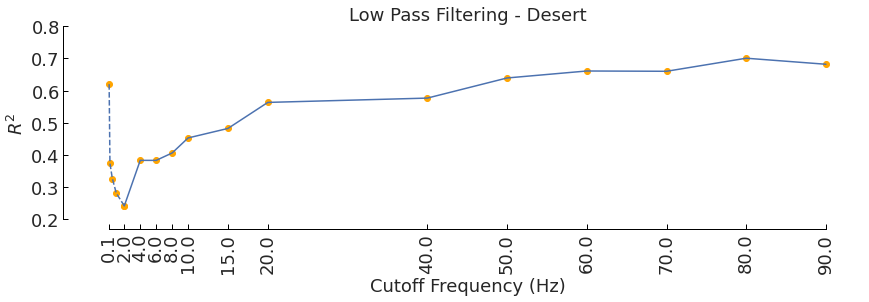

In [26]:
# cutoff=np.array([0.1,0.2,0.5,1,2,4,6,8,10,15,20,40,50,60,70,80,90])
# rsq=rs
# rsq=np.array([0.6203130980463978,0.3745363995992592,0.327073395020676, 0.2814948909942232,0.24205416850966,
#              0.38348641665523975,0.38348641665523975,0.4064829597057922,0.45311169229618875,
#              0.4826627957203161,0.5635516377812952, 0.5769321356148331,0.6394535507195294,
#              0.6611420518231501,0.6602473760004987,0.7008459671212011,0.682043273913716])

rsq=np.array([0.24205416850966,
             0.38348641665523975,0.38348641665523975,0.4064829597057922,0.45311169229618875,
             0.4826627957203161,0.5635516377812952, 0.5769321356148331,0.6394535507195294,
             0.6611420518231501,0.6602473760004987,0.7008459671212011,0.682043273913716])
rsq1=np.array([0.6203130980463978,0.3745363995992592,0.327073395020676, 0.2814948909942232,
              0.24205416850966])
cutoff=np.array([2,4,6,8,10,15,20,40,50,60,70,80,90])
cutoff1=np.array([0.1,0.2,0.5,1,2])
f,ax=plt.subplots(1,1,figsize=(12,4))
ax.plot(cutoff,rsq)
ax.plot(cutoff1,rsq1,'--',c='b')
ax.scatter(cutoff,rsq,c='orange')
ax.scatter(cutoff1,rsq1,c='orange')
ax.grid(False)
ax.set_xlabel('Cutoff Frequency (Hz)')
ax.set_ylabel('$R^2$')

mpl_functions.adjust_spines(ax,['left','bottom'],
                            spine_locations={}, 
                            smart_bounds=True,
                            xticks=[0.1,2,4,6,8,10,15,20,40,50,60,70,80,90],
#                             yticks = [-0.01,0.01],
                            linewidth=1)

plt.xticks(rotation=90)
ax.set_title('Low Pass Filtering - Desert')
f.tight_layout(pad=1)
figurefirst.mpl_functions.set_fontsize(f, 18)
f.savefig('../../Figure/LPF_OnCont.jpeg', dpi=300, bbox_inches = "tight")

In [ ]:
# def get_timed_rows_cont(same_time_location,dataframe_cont,duration_of_encounters):
#     y=dataframe_cont.iloc[same_time_location]
#     A = y.time.round(0) - duration_of_encounters
#     B = y.time.round(0)
#     timed_rows_cont = dataframe_cont.loc[(dataframe_cont.time > A) & (dataframe_cont.time < B)]
     
#     return np.mean(timed_rows_cont.odor)

# def get_timed_rows(dataframe,dataframe_cont,duration_of_encounters):
#     x = dataframe.sample(1)
#     A = x.mean_time.values.round(0) - duration_of_encounters
#     B = x.mean_time.values.round(0)

#     if (np.where(dataframe_cont.time.round(0)==B[0])[0].size == 0):
#         #find index of closest value in continuous data frame
#         same_time_location = dataframe_cont.iloc[(dataframe_cont['time']-B[0]).abs().argsort()[:1]].index[0]     
#     else:
#         same_time_location = np.where(dataframe_cont.time.round(0) == B[0])[0][0]
#     same_time_location = dataframe_cont.iloc[(dataframe_cont['time']-B[0]).abs().argsort()[:1]].index[0]
#     timed_rows_odor_mean = get_timed_rows_cont(same_time_location,dataframe_cont,duration_of_encounters)
#     timed_rows = dataframe.loc[(dataframe.mean_time > A[0]) & (dataframe.mean_time < B[0])]
#     return timed_rows,timed_rows_odor_mean
    
# def get_timed_encounter_stats(dataframe,dataframe_cont, distance_class, duration_of_encounters):
#     df_q = dataframe.query('type == ' + str(distance_class))   
#     df_q.reset_index(inplace=True, drop=True)     
        
#     df_q_cont = dataframe_cont.query('type == ' + str(distance_class))   
#     df_q_cont.reset_index(inplace=True, drop=True)     
    
#     Nrows,mean_conc = get_timed_rows(df_q,df_q_cont,duration_of_encounters)
#     avg_dist = np.mean(Nrows.avg_dist_from_source)
#     mean_time_whiff=np.mean(Nrows.mean_time)
# #     mean_conc=np.mean(Nrows_cont.odor)
#     pack_data=np.vstack([Nrows.mean_concentration,Nrows.mean_ef,Nrows.log_whiff,Nrows.whiff_ma,Nrows.std_whiff])
#     return pack_data,avg_dist,len(Nrows),mean_time_whiff,mean_conc


# def gather_stat_timed(dataframe,dataframe_cont, distance_class, duration_of_encounters,X,y,D,N,T,MC):
#     for i in range(500):
#         xx,dx,n,t,mc=get_timed_encounter_stats(dataframe, dataframe_cont,
#                                                distance_class, duration_of_encounters)
#         X.append(xx)
#         D.append(dx)
#         y.append(distance_class)
#         N.append(n)
#         T.append(t)
#         MC.append(mc)

#     return X,y,D,N,T,MC
